### Initialization, getting the data

In [172]:
import torch
import pickle
import numpy as np
import random

In [2]:
!wget ennucore.com/f/spectra.npz

--2024-02-16 05:39:32--  http://ennucore.com/f/spectra.npz
Resolving ennucore.com (ennucore.com)... 95.163.69.58
Connecting to ennucore.com (ennucore.com)|95.163.69.58|:80... connected.
HTTP request sent, awaiting response... 308 Permanent Redirect
Location: https://ennucore.com/f/spectra.npz [following]
--2024-02-16 05:39:32--  https://ennucore.com/f/spectra.npz
Connecting to ennucore.com (ennucore.com)|95.163.69.58|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104141050 (99M)
Saving to: ‘spectra.npz’

spectra.npz         100%[===================>]  99.32M  1.86MB/s    in 83s     

2024-02-16 05:40:56 (1.19 MB/s) - ‘spectra.npz’ saved [104141050/104141050]



In [3]:
spectra = np.load('spectra.npz')
sp620_raw, sp730_raw, labels620, labels730 = spectra['spectra_620'], spectra['spectra_730'], spectra['structures_620'], spectra['structures_730']
sp620_raw.shape, sp730_raw.shape, len(set(labels620))

((6400, 1024), (6300, 1024), 1500)

In [4]:
np.max(labels620)

1499.0

In [5]:
from scipy.signal import savgol_filter

# Define a function to apply the savgol filter to each spectrum
def apply_savgol_filter(data_array):
    filtered_data_array = []
    for spectra in data_array:
        filtered_spectra = [savgol_filter(spectrum, 15, 2) for spectrum in spectra]  # window size 5, polynomial order 2
        filtered_data_array.append(filtered_spectra)
    return np.array(filtered_data_array, dtype=object)

In [6]:
test_structures = np.arange(0, 1500, 15)
labels620_test = labels620[np.where(np.isin(labels620, test_structures))[0]]
labels620_train = labels620[np.where(1 - np.isin(labels620, test_structures))[0]]
sp620_test = sp620_raw[np.where(np.isin(labels620, test_structures))[0]]
sp620_train = sp620_raw[np.where(1 - np.isin(labels620, test_structures))[0]]
labels730_test = labels730[np.where(np.isin(labels730, test_structures))[0]]
labels730_train = labels730[np.where(1 - np.isin(labels730, test_structures))[0]]
sp730_test = sp730_raw[np.where(np.isin(labels730, test_structures))[0]]
sp730_train = sp730_raw[np.where(1 - np.isin(labels730, test_structures))[0]]
from sklearn.model_selection import train_test_split

# Splitting sp620 data into train and validation
sp620_train, sp620_val, labels620_train, labels620_val = train_test_split(
    sp620_train, labels620_train, test_size=0.07, random_state=42)

# Splitting sp730 data into train and validation
sp730_train, sp730_val, labels730_train, labels730_val = train_test_split(
    sp730_train, labels730_train, test_size=0.07, random_state=42)

labels620_test.shape, labels620_train.shape, sp620_train.shape, sp620_val.shape

((430,), (5552,), (5552, 1024), (418, 1024))

In [7]:
def recombine(left, right, left_labels, right_labels):
  N = 0
  for i in range(len(left)):
    for j in range(len(right)):
      if left_labels[i] == right_labels[j]:
        N += 1
  combined = np.zeros((N, 2048))
  combined_labels = np.zeros(N)
  k = 0
  for i in range(len(left)):
    for j in range(len(right)):
      if left_labels[i] == right_labels[j]:
        combined[k] = np.concatenate((left[i], right[j]))
        combined_labels[k] = left_labels[i]
        k += 1
  return combined, combined_labels

In [8]:
train_x, train_y = recombine(sp620_train, sp730_train, labels620_train, labels730_train)
val_x, val_y = recombine(sp620_val, sp730_val, labels620_val, labels730_val)
test_x, test_y = recombine(sp620_test, sp730_test, labels620_test, labels730_test)

In [9]:
# np.savez('combined.npz', train_x=train_x, train_y=train_y, val_x=val_x, val_y=val_y, )

In [34]:
train_x.shape

(25290, 2048)

### Augmenting the data and generating triplet batches

In [22]:
import torch
device = 'mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
def augment_spectrum(spectrum):
    assert len(spectrum) == 2048, "Input spectrum should have 2048 elements."

    # Normalize the original spectrum
    spectrum_norm = spectrum
    transformed = np.array(spectrum_norm)

    # Fourier Transform and normalize
    fourier_first_half = np.fft.fft(savgol_filter(spectrum[:1024], 15, 2)).real
    fourier_second_half = np.fft.fft(savgol_filter(spectrum[1024:], 15, 2)).real
    fourier_first_half_norm = fourier_first_half
    fourier_second_half_norm = fourier_second_half

    transformed = np.concatenate((transformed, fourier_first_half_norm, fourier_second_half_norm))

    # Logarithms and normalize
    log_values = np.log(np.abs(spectrum) + 1)  # Adding a small constant to avoid log(0)
    log_values_norm = log_values
    transformed = np.concatenate((transformed, log_values_norm))

    # Percentage calculations
    perc_first_half = lambda f: np.sum(spectrum[:1024] > f * np.max(spectrum[:1024])) / 1024
    perc_second_half = lambda f: np.sum(spectrum[1024:] > f * np.max(spectrum[1024:])) / 1024
    transformed = np.concatenate((transformed, [perc_first_half(0.5), perc_second_half(0.5), perc_first_half(0.2), perc_second_half(0.2), perc_first_half(0.8), perc_second_half(0.8)]))

    return transformed

In [24]:
X_train, y_train = torch.Tensor(np.array([augment_spectrum(sp) for sp in train_x])).to(device), torch.Tensor(train_y).to(device)
X_val, y_val = torch.Tensor(np.array([augment_spectrum(sp) for sp in val_x])).to(device), torch.Tensor(val_y).to(device)
X_test, y_test = torch.Tensor(np.array([augment_spectrum(sp) for sp in test_x])).to(device), torch.Tensor(test_y).to(device)

In [25]:
def get_triplet_batch(batch_size, x_all=X_train, y_all=y_train):
    """
    Further optimized function to generate a batch for triplet loss training,
    with checks to handle edge cases where the anchor may be the only example of its class.
    """
    # Calculate positive and negative indices for each class
    labels_unique = torch.unique(y_all)
    positive_indices = {}
    negative_indices = {}
    for label in labels_unique:
        pos_indices = (y_all == label).nonzero(as_tuple=True)[0]
        neg_indices = (y_all != label).nonzero(as_tuple=True)[0]
        if len(pos_indices) > 1:
            positive_indices[label.item()] = pos_indices
        negative_indices[label.item()] = neg_indices

    # Sample batch_size anchors at once
    anchor_indices = torch.randint(0, x_all.shape[0], (batch_size,))
    anchors = x_all[anchor_indices]
    anchor_labels = y_all[anchor_indices]

    # Initialize placeholders for positives and negatives
    positives = torch.zeros_like(anchors)
    negatives = torch.zeros_like(anchors)

    for i, anchor_idx in enumerate(anchor_indices):
        anchor_label = anchor_labels[i].item()

        # Handle the case where the anchor might be the only example of its class
        if len(positive_indices.get(anchor_label, [])) > 1:
            # Exclude the anchor index
            pos_indices = positive_indices[anchor_label]
            pos_indices = pos_indices[pos_indices != anchor_idx]
            positive_idx = pos_indices[torch.randint(0, len(pos_indices), (1,))]
            positives[i] = x_all[positive_idx]
        else:
            # This is a workaround: if there's only one example, use the anchor as positive
            # In a real scenario, you might want to handle this differently
            positives[i] = anchors[i]

        # Sample negatives from different labels
        neg_indices = negative_indices[anchor_label]
        negative_idx = neg_indices[torch.randint(0, len(neg_indices), (1,))]
        negatives[i] = x_all[negative_idx]

    # Transfer tensors to the device
    return anchors.to(device), positives.to(device), negatives.to(device)


In [26]:
X_train.shape, train_x.shape

(torch.Size([25290, 6150]), (25290, 2048))

In [27]:
X_train[1], y_train[1], torch.max(y_train)

(tensor([39.0000, 29.0000, 24.0000,  ...,  0.9990,  0.3271,  0.2959],
        device='mps:0'),
 tensor(927., device='mps:0'),
 tensor(1499., device='mps:0'))

In [28]:
get_triplet_batch(1)

(tensor([[21.0000, 33.0000, 17.0000,  ...,  0.9990,  0.1094,  0.1318]],
        device='mps:0'),
 tensor([[13.0000, 25.0000, 23.0000,  ...,  0.9990,  0.0781,  0.1318]],
        device='mps:0'),
 tensor([[297.0000, 317.0000, 299.0000,  ...,   0.9990,   0.6064,   0.4141]],
        device='mps:0'))

## Functions for testing

In [29]:
import numpy as np
from collections import Counter
from scipy.spatial import distance

def knn_classifier(x_data, y_data, query_points, k=5):
    # Compute the Euclidean distances between all data points and query points
    distances = distance.cdist(query_points, x_data, 'euclidean')
    # Find the indices of the k nearest neighbors for each query point
    nearest_indices = np.argsort(distances, axis=1)[:, :k]
    # Get the labels of the nearest neighbors
    nearest_labels = y_data[nearest_indices]
    # Determine the most common label for each query point
    predicted_labels = []
    for labels in nearest_labels:
        most_common = Counter(labels).most_common(1)
        predicted_labels.append(most_common[0][0])
    return np.array(predicted_labels)

In [30]:
def test_model(model, x_data, y_data, x_data_2=None, y_data_2=None, N=1000):
    if hasattr(model, 'forward_one'):
        model.train(False)
        model = model.forward_one
    if x_data_2 is None:
        selected = np.random.choice(np.arange(len(x_data)), N, replace=False)
        x_data_2, y_data_2 = x_data[selected], y_data[selected]
        excluded = ~np.isin(np.arange(len(x_data)), selected)
        x_data, y_data = x_data[excluded], y_data[excluded]

    with torch.no_grad():
        x_emb = model(x_data).cpu().numpy()
        x2_emb = model(x_data_2).cpu().numpy()
        y_classified = knn_classifier(x_emb, y_data.cpu().numpy(), x2_emb)
    return np.mean(y_classified == y_data_2.cpu().numpy())

In [31]:
test_model(lambda x: x, X_train, y_train, X_val, y_val)

0.19895287958115182

## TripletNet

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim

class TripletNet(nn.Module):
    def __init__(self, input_dim):
        super(TripletNet, self).__init__()
        self.embedding = nn.Sequential(
            nn.BatchNorm1d(input_dim),
            nn.Linear(input_dim, 2048),
            nn.LeakyReLU(),
            nn.BatchNorm1d(2048),
            nn.Linear(2048, 1024),
            # nn.LeakyReLU(),
            # nn.BatchNorm1d(1024),
            # nn.Linear(1024, 512),
            # nn.LeakyReLU(),
            # nn.BatchNorm1d(512),
            # nn.Linear(1024, 512),
        )

    def forward_one(self, x):
        return self.embedding(x)


    def forward(self, anchor, positive, negative):
        anchor_embedding = self.forward_one(anchor)
        positive_embedding = self.forward_one(positive)
        negative_embedding = self.forward_one(negative)
        return anchor_embedding, positive_embedding, negative_embedding

In [43]:
# Initialize the model and loss function
input_dim = 6150
model = TripletNet(input_dim).to(device)
criterion = nn.TripletMarginLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
losses = []
val_losses = []
model_scores = []
model.train(True)

# Training settings
num_epochs = 50
batch_size = 1024

for epoch in range(num_epochs):
    for _ in range(len(X_train) // (3*batch_size)):
        # Generate a triplet batch
        anchor, positive, negative = get_triplet_batch(batch_size)
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        # Forward pass
        anchor_embedding, positive_embedding, negative_embedding = model(anchor, positive, negative)

        # Compute the loss
        loss = criterion(anchor_embedding, positive_embedding, negative_embedding)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    l = loss.item()
    losses.append(l)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {l:.4f}")
    with torch.no_grad():
        anchor, positive, negative = get_triplet_batch(batch_size * 10, X_val, y_val)
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        anchor_embedding, positive_embedding, negative_embedding = model(anchor, positive, negative)
        val_l = criterion(anchor_embedding, positive_embedding, negative_embedding)
        val_losses.append(val_l)
        model_scores.append(test_model(model, X_train, y_train, X_val, y_val))
        print(f'Val loss: {val_l:.4f}')
    print(f'FPR: {get_model_fpr(model)}')


Epoch [1/50], Loss: 0.2168
Val loss: 0.0401
FPR: 0.08614958448753463
Epoch [2/50], Loss: 0.1087
Val loss: 0.0252
FPR: 0.04886426592797784
Epoch [3/50], Loss: 0.0837
Val loss: 0.0183
FPR: 0.04742382271468144
Epoch [4/50], Loss: 0.1296
Val loss: 0.0336
FPR: 0.08653739612188366
Epoch [5/50], Loss: 0.1036
Val loss: 0.0134
FPR: 0.05030470914127424
Epoch [6/50], Loss: 0.0967
Val loss: 0.0207
FPR: 0.03916897506925208
Epoch [7/50], Loss: 0.1540
Val loss: 0.0222
FPR: 0.042271468144044325
Epoch [8/50], Loss: 0.0612
Val loss: 0.0204
FPR: 0.053074792243767314
Epoch [9/50], Loss: 0.1176
Val loss: 0.0140
FPR: 0.03041551246537396
Epoch [10/50], Loss: 0.1706
Val loss: 0.0316
FPR: 0.05844875346260388
Epoch [11/50], Loss: 0.0641
Val loss: 0.0147
FPR: 0.0260387811634349
Epoch [12/50], Loss: 0.1305
Val loss: 0.0262
FPR: 0.04520775623268698
Epoch [13/50], Loss: 0.0871
Val loss: 0.0109
FPR: 0.032354570637119114
Epoch [14/50], Loss: 0.0213
Val loss: 0.0176
FPR: 0.04481994459833795
Epoch [15/50], Loss: 0.1542

KeyboardInterrupt: 

In [80]:
def label_matrix(labels):
    n = len(labels)
    matrix = torch.zeros((n, n))

    for i in range(n):
        for j in range(i+1, n):
            if labels[i] != labels[j]:
                matrix[i][j] = 1
                matrix[j][i] = 1
    return matrix

def get_indices_for_label(label, n):
    indices = torch.nonzero(y_train == label).squeeze(1)
    n_samples = min(len(indices), n)
    random_indices = torch.randint(low=0, high=len(indices), size=(n_samples,))
    return indices[random_indices]

def batch_loss(batch_indices):
    batch_x = X_train[batch_indices].to(device)
    batch_y = y_train[batch_indices].to(device)
    emb_b_x = model.forward_one(batch_x)
    distances = torch.cdist(emb_b_x, emb_b_x)
    vals = (torch.sigmoid(5 * distances / torch.mean(distances)) - 0.5)*2
    return torch.mean((vals - label_matrix(batch_y).to(device))**2)


def get_batch_indices():
    n_samples = 40
    labels = y_train[torch.randint(0, len(y_train), (n_samples,))]
    return torch.concatenate(tuple(get_indices_for_label(l, torch.randint(1, 5, tuple())) for l in labels))

In [81]:
# Initialize the model and loss function
input_dim = 6150
model = TripletNet(input_dim).to(device)
criterion = nn.TripletMarginLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
losses = []
val_losses = []
model_scores = []
model.train(True)

# Training settings
num_epochs = 10
batch_size = 500

for epoch in range(num_epochs):
    for _ in range(len(X_train) // (batch_size)):
        loss = batch_loss(get_batch_indices())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    l = loss.item()
    losses.append(l)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {l:.4f}")
    with torch.no_grad():
        anchor, positive, negative = get_triplet_batch(batch_size * 10, X_val, y_val)
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        anchor_embedding, positive_embedding, negative_embedding = model(anchor, positive, negative)
        val_l = criterion(anchor_embedding, positive_embedding, negative_embedding)
        val_losses.append(val_l)
        model_scores.append(test_model(model, X_train, y_train, X_val, y_val))
        print(f'Val loss: {val_l:.4f}')
    print(f'FPR: {get_model_fpr(model)}')


Epoch [1/10], Loss: 0.0110
Val loss: 0.0156
FPR: 0.05628808864265928
Epoch [2/10], Loss: 0.0107
Val loss: 0.0208
FPR: 0.03839335180055402
Epoch [3/10], Loss: 0.0102
Val loss: 0.0167
FPR: 0.04044321329639889
Epoch [4/10], Loss: 0.0087
Val loss: 0.0186
FPR: 0.03479224376731302
Epoch [5/10], Loss: 0.0104
Val loss: 0.0049
FPR: 0.02149584487534626
Epoch [6/10], Loss: 0.0113
Val loss: 0.0109
FPR: 0.018781163434903048
Epoch [7/10], Loss: 0.0079
Val loss: 0.0055
FPR: 0.014238227146814405
Epoch [8/10], Loss: 0.0073
Val loss: 0.0084
FPR: 0.012299168975069252
Epoch [9/10], Loss: 0.0064
Val loss: 0.0112
FPR: 0.01113573407202216
Epoch [10/10], Loss: 0.0094
Val loss: 0.0054
FPR: 0.011246537396121884


In [82]:
for epoch in range(num_epochs):
    for _ in range(len(X_train) // (batch_size)):
        loss = batch_loss(get_batch_indices())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    l = loss.item()
    losses.append(l)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {l:.4f}")
    with torch.no_grad():
        anchor, positive, negative = get_triplet_batch(batch_size * 10, X_val, y_val)
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        anchor_embedding, positive_embedding, negative_embedding = model(anchor, positive, negative)
        val_l = criterion(anchor_embedding, positive_embedding, negative_embedding)
        val_losses.append(val_l)
        model_scores.append(test_model(model, X_train, y_train, X_val, y_val))
        print(f'Val loss: {val_l:.4f}')
    print(f'FPR: {get_model_fpr(model)}')

KeyboardInterrupt: 

In [ ]:
from matplotlib import pyplot as plt
plt.plot(model_scores)
plt.title("Classification rate on the validation dataset")
plt.xlabel("Epoch")
plt.savefig('class_rate.svg')

In [ ]:
test_model(model, X_train, y_train, X_val, y_val)

In [ ]:
test_model(lambda x: x, X_test, y_test, N=400), test_model(model, X_test, y_test, N=400)

In [84]:
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt

def calculate_rates(x_emb, labels, cutoff):
    # Calculate pairwise distances between all embeddings
    pairwise_dist = distance.squareform(distance.pdist(x_emb, 'euclidean'))
    # Determine whether pairs are of the same class
    same_class = labels[:, None] == labels[None, :]
    # Determine which pairs are below the cutoff distance
    within_cutoff = pairwise_dist < cutoff

    # True Positives (TP): Same class and within cutoff
    TP = np.sum(within_cutoff & same_class)
    # False Positives (FP): Different class but within cutoff
    FP = np.sum(within_cutoff & ~same_class)
    # False Negatives (FN): Same class but above cutoff
    FN = np.sum(~within_cutoff & same_class)
    # True Negatives (TN): Different class and above cutoff
    TN = np.sum(~within_cutoff & ~same_class)

    # Calculate rates
    TPR = TP / (TP + FN) if TP + FN > 0 else 0  # True Positive Rate
    FPR = FP / (FP + TN) if FP + TN > 0 else 0  # False Positive Rate
    FNR = FN / (TP + FN) if TP + FN > 0 else 0  # False Negative Rate

    return TPR, FPR, FNR

def plot_rates(x_emb, labels, distances, postfix='', filename=''):
    TPRs, FPRs, FNRs, TNRs = [], [], [], []
    pairwise_dist = distance.squareform(distance.pdist(x_emb, 'euclidean'))
    for cutoff in distances:
        # print(cutoff)
        same_class = labels[:, None] == labels[None, :]
        # Determine which pairs are below the cutoff distance
        within_cutoff = pairwise_dist < cutoff

        # True Positives (TP): Same class and within cutoff
        TP = np.sum(within_cutoff & same_class)
        # False Positives (FP): Different class but within cutoff
        FP = np.sum(within_cutoff & ~same_class)
        # False Negatives (FN): Same class but above cutoff
        FN = np.sum(~within_cutoff & same_class)
        # True Negatives (TN): Different class and above cutoff
        TN = np.sum(~within_cutoff & ~same_class)

        # Calculate rates
        TPR = TP / (TP + FN) if TP + FN > 0 else 0  # True Positive Rate
        FPR = FP / (FP + TN) if FP + TN > 0 else 0  # False Positive Rate
        FNR = FN / (TP + FN) if TP + FN > 0 else 0  # False Negative Rate
        TNR = TN / (TN + FP) if TN + FP > 0 else 0

        TPRs.append(TPR)
        FPRs.append(FPR)
        FNRs.append(FNR)
        TNRs.append(TNR)

    if any(tpr > 0.95 for tpr in TPRs):
        print('FPR@0.95')
        ind = [i for i, tpr in enumerate(TPRs) if tpr > 0.95][0]
        print(FPRs[ind], f'(d={distances[ind]})')
        print()
    plt.figure(figsize=(10,6))
    plt.plot(distances, TPRs, label='True Positive Rate (Correct Validation)')
    plt.plot(distances, FPRs, label='False Positive Rate')
    plt.plot(distances, FNRs, label='False Negative Rate')
    plt.plot(distances, TNRs, label='True Negative Rate')
    plt.title('Rates vs Cutoff Distance' + postfix)
    plt.xlabel('Cutoff Distance')
    plt.ylabel('Rate')
    plt.legend()
    plt.grid(True)
    if filename:
      plt.savefig(filename)
    plt.show()


def get_fpr(x_emb, labels, distances, tpr_cutoff=0.95):
    TPRs, FPRs, FNRs, TNRs = [], [], [], []
    pairwise_dist = distance.squareform(distance.pdist(x_emb, 'euclidean'))
    for cutoff in distances:
        # print(cutoff)
        same_class = labels[:, None] == labels[None, :]
        # Determine which pairs are below the cutoff distance
        within_cutoff = pairwise_dist < cutoff

        # True Positives (TP): Same class and within cutoff
        TP = np.sum(within_cutoff & same_class)
        # False Positives (FP): Different class but within cutoff
        FP = np.sum(within_cutoff & ~same_class)
        # False Negatives (FN): Same class but above cutoff
        FN = np.sum(~within_cutoff & same_class)
        # True Negatives (TN): Different class and above cutoff
        TN = np.sum(~within_cutoff & ~same_class)

        # Calculate rates
        TPR = TP / (TP + FN) if TP + FN > 0 else 0  # True Positive Rate
        FPR = FP / (FP + TN) if FP + TN > 0 else 0  # False Positive Rate
        FNR = FN / (TP + FN) if TP + FN > 0 else 0  # False Negative Rate
        TNR = TN / (TN + FP) if TN + FP > 0 else 0
        if TPR > tpr_cutoff:
            return FPR


def get_model_fpr(m):
    with torch.no_grad():
        return get_fpr(model.forward_one(X_val).cpu().numpy(), y_val.cpu().numpy(), np.linspace(5, 100, num=100))

In [ ]:

# distances = np.linspace(0, 10, num=60)
# with torch.no_grad():
#   plot_rates(model.forward_one(X_train).cpu().numpy(), y_train.cpu().numpy(), distances, ": previously seen spectra", "confusion-train.svg")


In [ ]:
with torch.no_grad():
  test_embeddings = model.forward_one(X_test).cpu().numpy()
print(np.max(test_embeddings))
print(test_embeddings.shape)
print(np.min(test_embeddings))

In [42]:
get_model_fpr(model)

0.018060941828254847

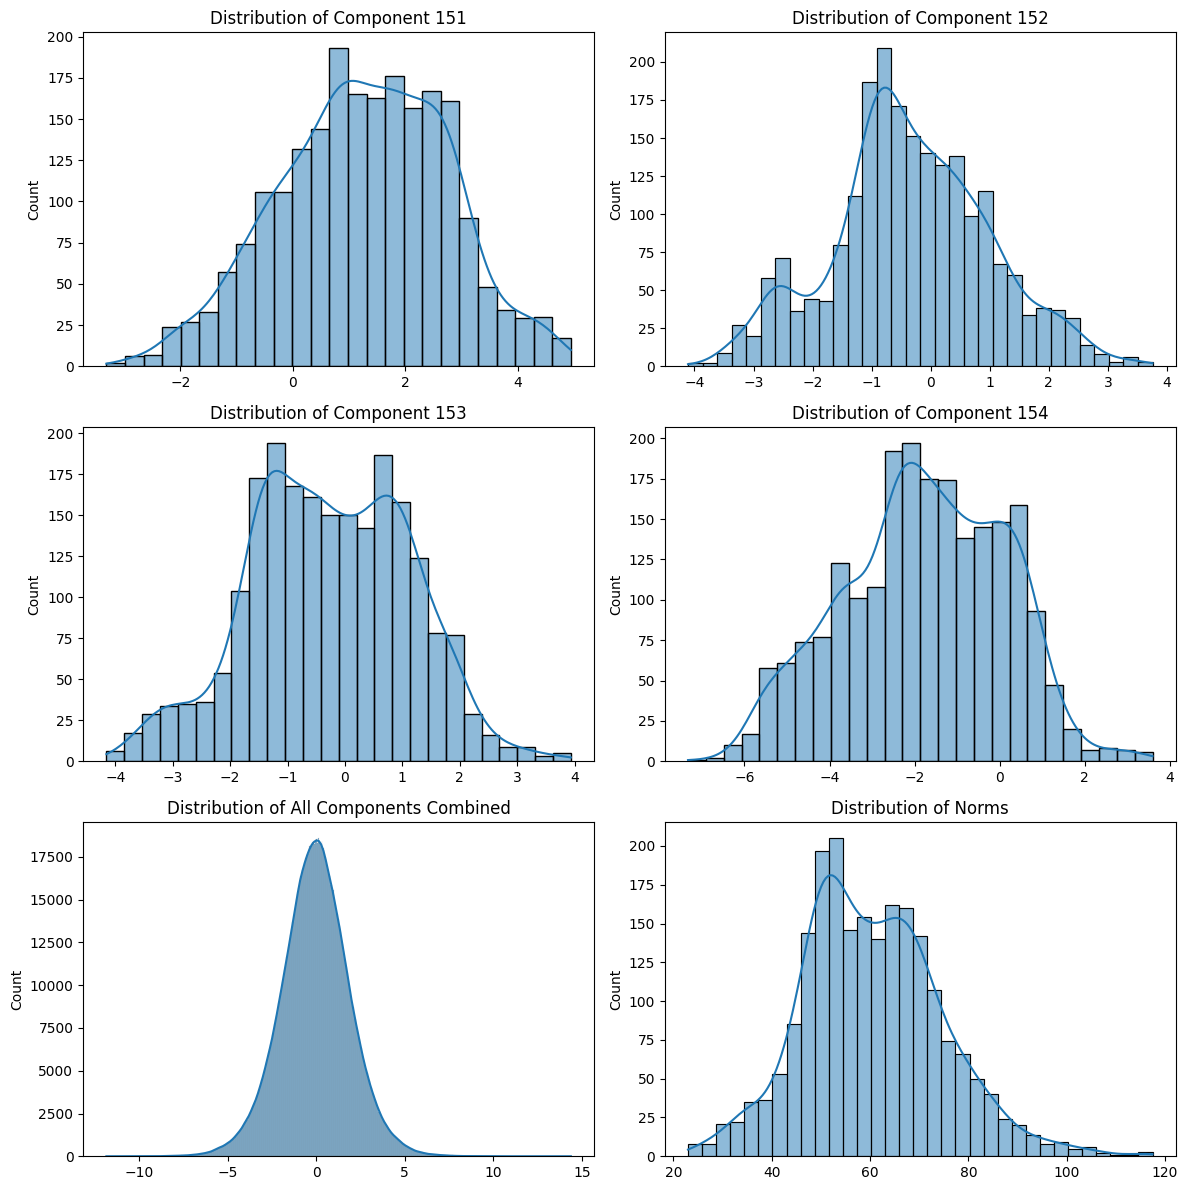

In [171]:
import seaborn as sns

with torch.no_grad():
    res = model.forward_one(X_test).cpu().numpy()
    # sns.distplot(res[:, 151])
    # 1. Define the figure and axes for 6 subplots (4 components + 1 for .ravel() + 1 for norms)
    fig, axes = plt.subplots(3, 2, figsize=(12, 12))  # Adjust size as needed
    axes = axes.ravel()
    
    # 2. Plot distributions for 4 specific components
    components = [151, 152, 153, 154]  # Just an example, replace with your components of interest
    for i, comp in enumerate(components):
        sns.histplot(res[:, comp], ax=axes[i], kde=True)  # Using histplot instead of distplot
        axes[i].set_title(f'Distribution of Component {comp}')
    
    # 3. Plot distribution for all components combined (.ravel())
    sns.histplot(res.ravel(), ax=axes[4], kde=True)
    axes[4].set_title('Distribution of All Components Combined')
    
    # 4. Calculate and plot the distribution of the norms of each row
    norms = np.linalg.norm(res, axis=1)
    sns.histplot(norms, ax=axes[5], kde=True)
    axes[5].set_title('Distribution of Norms')
    
    plt.tight_layout()
    plt.savefig('some-distributions.svg')
    plt.show()

FPR@0.95
0.01407202216066482 (d=27.11864406779661)



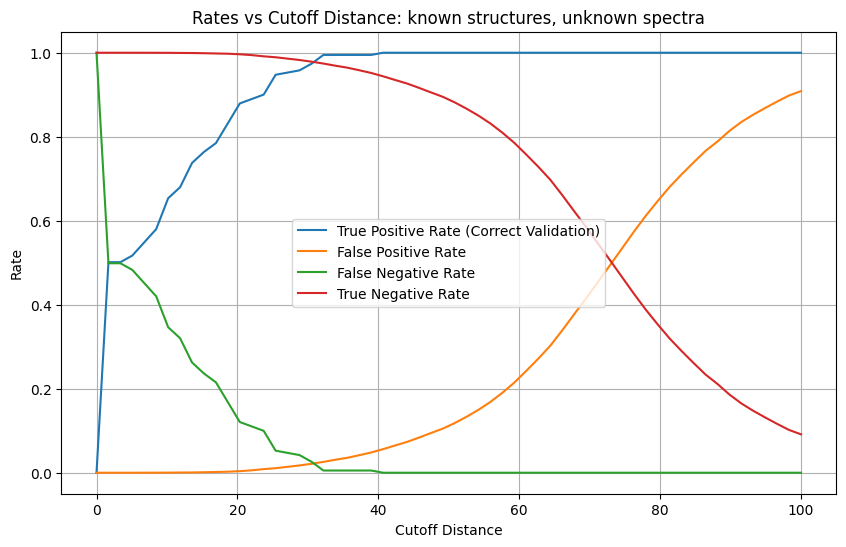

In [85]:
distances = np.linspace(0, 100, num=60)
with torch.no_grad():
  plot_rates(model.forward_one(X_val).cpu().numpy(), y_val.cpu().numpy(), distances, ": known structures, unknown spectra", "confusion-val.svg")

FPR@0.95
0.026494045716324258 (d=32.20338983050847)



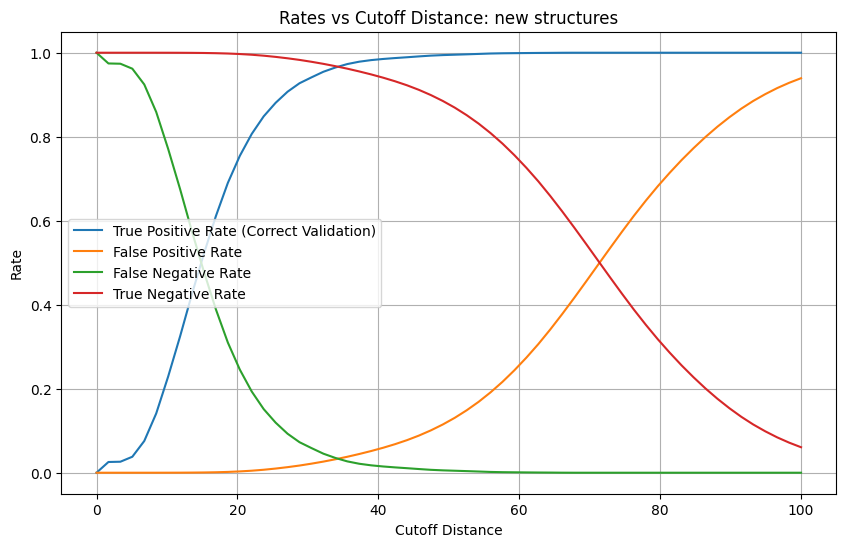

In [134]:
distances = np.linspace(0, 100, num=60)
with torch.no_grad():
  plot_rates(model.forward_one(X_test).cpu().numpy(), y_test.cpu().numpy(), distances, ": new structures", "confusion-test.svg")

In [ ]:
# distances = np.linspace(0, 5, num=50)
# with torch.no_grad():
#   plot_rates(X_train.cpu().numpy(), y_train.cpu().numpy(), distances)


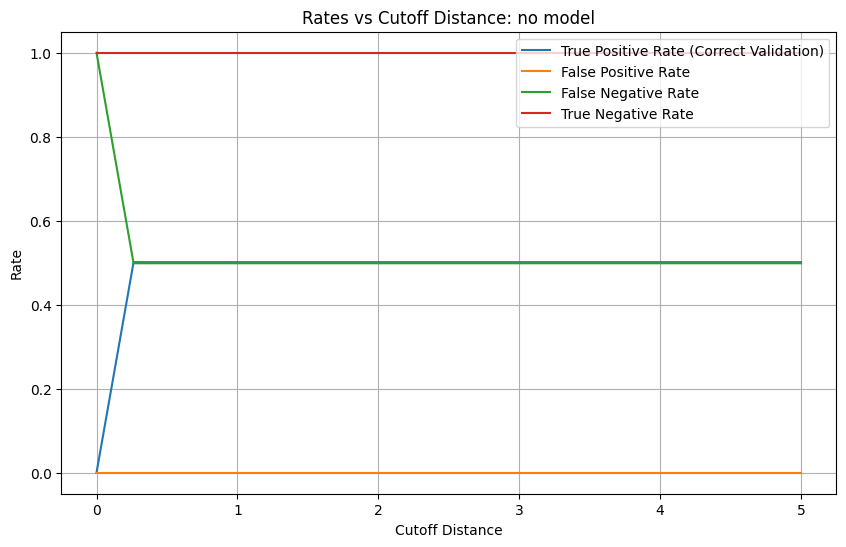

In [132]:
distances = np.linspace(0, 5, num=20)
with torch.no_grad():
  plot_rates(X_val.cpu().numpy(), y_val.cpu().numpy(), distances, ": no model", "confusion-nomodel-test.svg")

FPR@0.95
0.3048753462603878 (d=1497.4874371859298)



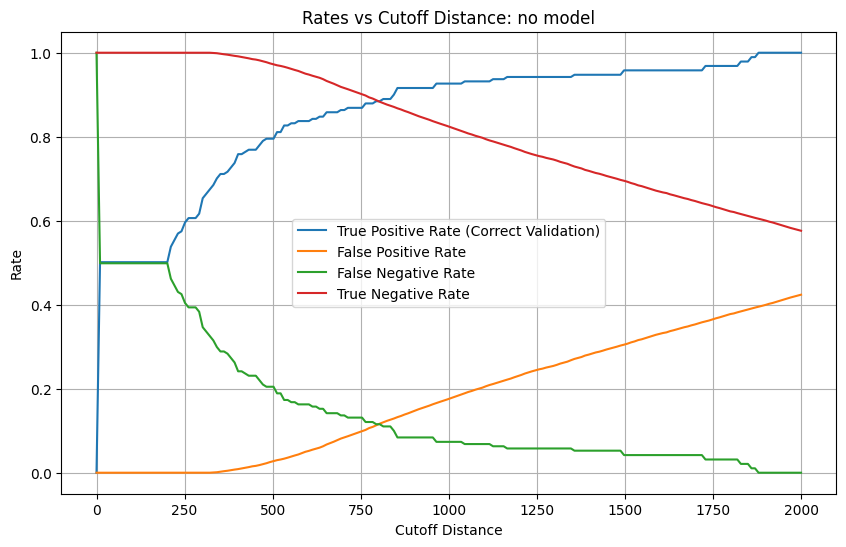

In [133]:
distances = np.linspace(0, 2000, num=200)
with torch.no_grad():
  plot_rates(val_x, val_y, distances, ": no model", "confusion-nomodel-test.svg")

#### Results for different configurations
Baseline model score is 0.136, for triplet with LReLu and 30 epochs and 2048-1024-256-64 it's 0.33. And 0.9375 (vs 0.93 baseline) on the second test

With 512 as the last layer (no 64): 0.36, (0.9175, 0.9475)

/var/folders/1x/t909rs3x6rx12g06tz4zy9740000gn/T/ipykernel_23646/3199309540.py:19: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(same_class_distances, label='Same Structure', shade=True, clip=(0, None))
/var/folders/1x/t909rs3x6rx12g06tz4zy9740000gn/T/ipykernel_23646/3199309540.py:20: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(diff_class_distances, label='Different Structures', shade=True, clip=(0, None))


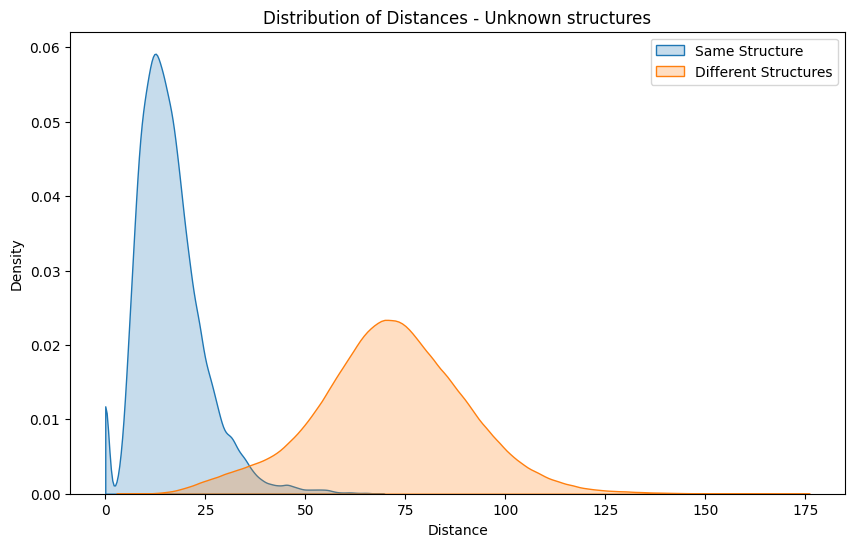

/var/folders/1x/t909rs3x6rx12g06tz4zy9740000gn/T/ipykernel_23646/3199309540.py:19: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(same_class_distances, label='Same Structure', shade=True, clip=(0, None))
/var/folders/1x/t909rs3x6rx12g06tz4zy9740000gn/T/ipykernel_23646/3199309540.py:20: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(diff_class_distances, label='Different Structures', shade=True, clip=(0, None))


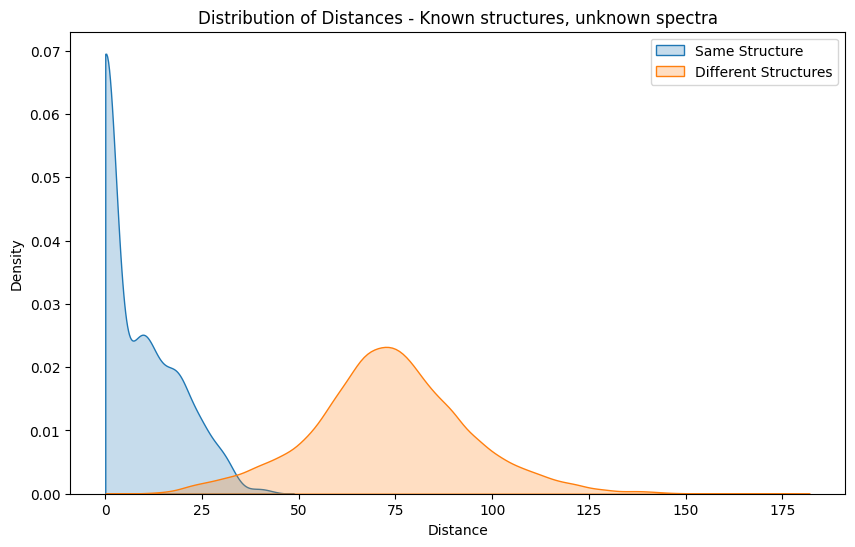

/var/folders/1x/t909rs3x6rx12g06tz4zy9740000gn/T/ipykernel_23646/3199309540.py:19: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(same_class_distances, label='Same Structure', shade=True, clip=(0, None))
/var/folders/1x/t909rs3x6rx12g06tz4zy9740000gn/T/ipykernel_23646/3199309540.py:20: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(diff_class_distances, label='Different Structures', shade=True, clip=(0, None))


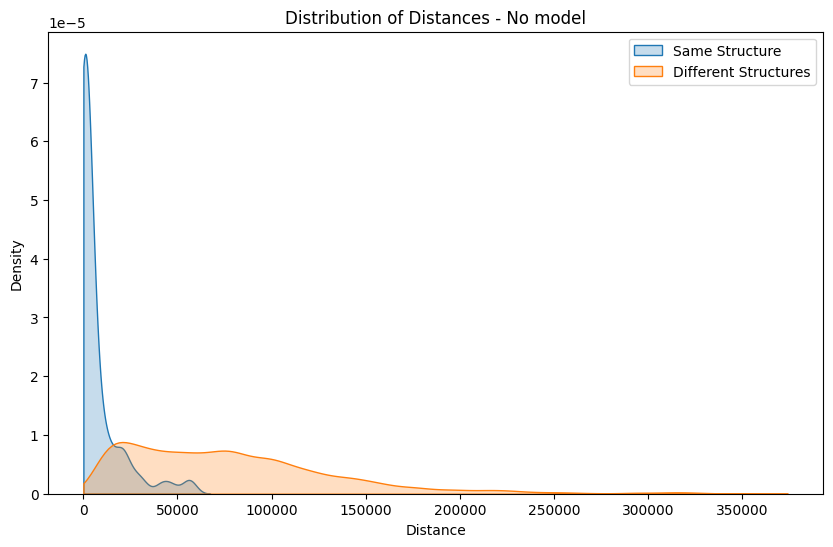

In [178]:
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distance_distributions(x_emb, labels, t_postfix='', filename=''):
    # Calculate pairwise distances between all embeddings
    pairwise_dist = distance.squareform(distance.pdist(x_emb, 'euclidean'))
    
    # Determine whether pairs are of the same class
    same_class = labels[:, None] == labels[None, :]
    
    # Extract distances for same class and different class pairs
    same_class_distances = pairwise_dist[same_class]
    diff_class_distances = pairwise_dist[~same_class]
    
    # Plot the distributions
    plt.figure(figsize=(10, 6))
    sns.kdeplot(same_class_distances, label='Same Structure', shade=True, clip=(0, None))
    sns.kdeplot(diff_class_distances, label='Different Structures', shade=True, clip=(0, None))
    plt.title('Distribution of Distances' + t_postfix)
    plt.xlabel('Distance')
    plt.ylabel('Density')
    plt.legend()
    if filename:
        plt.savefig(filename)
    plt.show()

# Assuming you have the model and X_test, y_test available
with torch.no_grad():
    test_embeddings = model.forward_one(X_test).cpu().numpy()
    plot_distance_distributions(test_embeddings, y_test.cpu().numpy(), ' - Unknown structures', 'distance-distrib.svg')
    val_embeddings = model.forward_one(X_val).cpu().numpy()
    plot_distance_distributions(val_embeddings, y_val.cpu().numpy(), ' - Known structures, unknown spectra', 'distance-distrib-val.svg')
    plot_distance_distributions(X_val.cpu().numpy(), y_val.cpu().numpy(), ' - No model', 'distance-distrib-nomodel.svg')

## Test on different spectra

In [179]:
!ls

Unclonix.ipynb                  mat-confusion-15x15-max32.2.svg
combined.npz                    mat-confusion-15x15-max80.svg
confusion-nomodel-test.svg      mat-confusion-17x17-max32.2.svg
confusion-test.svg              mat-confusion-20x20-max32.2.svg
confusion-val.svg               mat-confusion-20x20-max80.svg
distance-distrib-nomodel.svg    mat-confusion-4x4-max32.2.svg
distance-distrib-val.svg        mat-confusion-4x4-max80.svg
distance-distrib.svg            mat-confusion-5x5-max32.2.svg
mat-confusion-10x10-max32.2.svg mat-confusion-5x5-max80.svg
mat-confusion-10x10-max80.svg   some-distributions.svg
mat-confusion-13x13-max32.2.svg spectra.npz
mat-confusion-13x13-max80.svg   spectra_data_combined_final.npz


In [195]:
new_spectra = np.load('spectra_data_combined_final.npz', allow_pickle=True)

In [196]:
new_spectra['data_620'].tolist().keys()

dict_keys(['10x10', '13x13', '14x14', '15x15', '17x17', '20x20', '4x4', '4x4_(3)', '5x5'])

In [197]:
# new_spectra['data_620'].tolist()['8x8'].shape, new_spectra['data_730'].tolist()['4x4_(3)'].shape

In [198]:
new_data_620 = new_spectra['data_620'].tolist()
new_data_730 = new_spectra['data_730'].tolist()

In [199]:
new_data_620['10x10'].shape

(100, 1024)

In [200]:
new_data_combined = {key: np.concatenate((new_data_620[key], new_data_620[key]), axis=1) for key in new_data_620.keys()}

In [201]:
new_data_c = {key: torch.Tensor(np.array([augment_spectrum(sp) for sp in new_data_combined[key]])).to(device) for key in new_data_620.keys()}

In [202]:
with torch.no_grad():
  new_data_emb = {key: model.forward_one(new_data_c[key]).cpu().numpy() for key in new_data_c.keys()}

In [203]:
new_data_emb.keys(), new_data_emb['10x10'].shape

(dict_keys(['10x10', '13x13', '14x14', '15x15', '17x17', '20x20', '4x4', '4x4_(3)', '5x5']),
 (100, 1024))

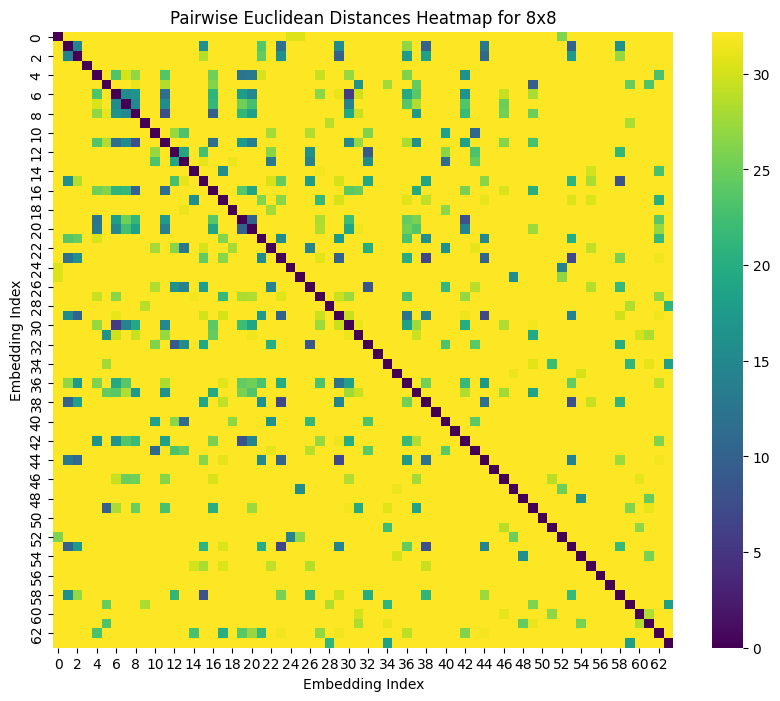

In [194]:
# Re-import necessary libraries after code execution state reset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist

# Since the actual embeddings data `new_data_emb` is not accessible due to reset, we will simulate a similar structure
# for demonstration purposes. This code block should be adapted to load or reference your actual embeddings data.


# Plotting the heatmap of pairwise Euclidean distances between embeddings for demonstration
structure = '8x8'  # Example structure key
embeddings = new_data_emb[structure]  # Example embeddings for this structure

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Calculating pairwise Euclidean distances between embeddings
distances = cdist(embeddings, embeddings, 'euclidean')

# Creating the heatmap
plt.figure(figsize=(10, 8))
vmax=80   # 32.2
sns.heatmap(distances, cmap="viridis", vmax=vmax)
plt.title(f'Pairwise Euclidean Distances Heatmap for {structure}')
plt.xlabel('Embedding Index')
plt.ylabel('Embedding Index')

plt.savefig(f'mat-confusion-{structure}-max{vmax}.svg')
plt.show()


## Classifier without the last layer model